# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

Word-based and character-based language models differ primarily in the unit of text they process and generate.

### Word-based Language Model:

- **Unit of Text**: Processes text one word at a time.
- **Vocabulary**: Larger vocabulary consisting of distinct words encountered during training.
- **Computation**: Generally more efficient in generating text because each operation produces a whole word, leading to faster generation of complete sentences.
- **Context**: May capture long-range dependencies more effectively due to the larger unit size (words).
- **Limitations**: Struggles with out-of-vocabulary (OOV) words and might not handle morphological variations or spelling errors well.

### Character-based Language Model:

- **Unit of Text**: Processes text one character at a time.
- **Vocabulary**: Smaller vocabulary consisting of distinct characters (letters, punctuation, etc.).
- **Computation**: Generally slower in generating text because each operation produces only one character.
- **Context**: May struggle to capture long-range dependencies effectively due to the smaller unit size (characters).
- **Flexibility**: Better at handling OOV words, morphological variations, and spelling errors, as it can generate any word character by character.

Both types have their advantages and disadvantages, and the choice between them depends on the specific application and requirements. Hybrid models that combine aspects of both are also increasingly common.

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [1]:
!wget https://raw.githubusercontent.com/joeymach/Leveraging-VAE-to-generate-molecules/master/250k_smiles.csv

--2023-09-06 21:16:52--  https://raw.githubusercontent.com/joeymach/Leveraging-VAE-to-generate-molecules/master/250k_smiles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22606589 (22M) [text/plain]
Saving to: ‘250k_smiles.csv’

250k_smiles.csv     100%[===================>]  21.56M  --.-KB/s    in 0.05s   

2023-09-06 21:16:54 (438 MB/s) - ‘250k_smiles.csv’ saved [22606589/22606589]



Display the first rows of the dataframe

In [39]:
import pandas as pd

df = pd.read_csv('/content/250k_smiles.csv')

df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [40]:
df['size'] = len(df.smiles)
biggest = df.sort_values('size', ascending=False).head(1).smiles
df.drop('size', inplace=True, axis=1)
biggest

0    CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n
Name: smiles, dtype: object


Code a function **unic_characters(string)** which return the unic characters in a string


In [41]:
def unique_characters(s: str):
  test = set(s)
  return test

In [42]:
assert(unique_characters('azjjd') == set(['a','z','j','d']))

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [43]:
from numpy import character
def find_unique_chars(series):
    return set(''.join(series))

characters = find_unique_chars(df.smiles)
print(characters)
print(len(characters))

{'#', 's', '+', 'n', 'H', '=', '4', '\\', '\n', 'N', ']', 'P', '@', 'F', '1', 'I', '-', 'c', 'o', '[', 'S', '(', '3', 'O', '6', 'r', '7', '/', 'C', '2', 'l', ')', '5', '8', 'B'}
35


Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [44]:
def map_char_to_int(unic_chars):
  dic = {}
  for i, e in enumerate(unic_chars):
    dic[e] = i
  return dic

def map_int_to_char(unic_chars):
  res = []
  for e in unic_chars:
    res.append(e)
  return res

For each smile molecule add the ending token to it

## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

 n_features is the dimension of the feature encoding (1 for integer encoding).

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [45]:
def build_X_and_y(string, i_char, seq_lenght):
  X = string[i_char: i_char + seq_lenght]
  y = string[i_char + seq_lenght]
  return X,y

print(build_X_and_y('abcdefgj', 3, 3))

('def', 'g')


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [46]:
!pip install tdqm

In [47]:
from tqdm import tqdm

tokenizer = map_char_to_int(characters)
seq_len = 4
X_train = []
y_train = []
for e in tqdm(df.smiles):
  for i in range(len(e)):
    if (i + seq_len) >= len(e):
      break
    X,y = build_X_and_y(e, i, seq_len)
    X_train.append([tokenizer[c] for c in X])
    y_train.append(tokenizer[y])

100%|██████████| 249455/249455 [00:18<00:00, 13364.88it/s]


Create numpy arrays from the lists

In [48]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
y_train.shape
X = X_train.copy()
y = y_train.copy()

(10305101, 4)


Reshape the X numpy array (n_examples, seq_lenght, 1)

In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
X_train.shape

(10305101, 4, 1)

Normalize X by dividing each values by the total number of unic characters

In [50]:
X_train = X_train / len(characters)
X_train

array([[[0.8       ],
        [0.8       ],
        [0.6       ],
        [0.8       ]],

       [[0.8       ],
        [0.6       ],
        [0.8       ],
        [0.88571429]],

       [[0.6       ],
        [0.8       ],
        [0.88571429],
        [0.6       ]],

       ...,

       [[0.45714286],
        [0.28571429],
        [0.88571429],
        [0.8       ]],

       [[0.28571429],
        [0.88571429],
        [0.8       ],
        [0.8       ]],

       [[0.88571429],
        [0.8       ],
        [0.8       ],
        [0.4       ]]])

In [51]:
def preprocess(X):
  X = np.reshape(X, (X.shape[0], seq_len, 1))
  return X / len(characters)



Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [52]:
!pip install tensorflow

In [53]:
from tensorflow.keras.utils import to_categorical

vocab_size = len(tokenizer)  # Number of unique tokens
y_train_one_hot = to_categorical(y_train, num_classes=vocab_size)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the model
model = Sequential()

# First LSTM layer with 128 neurons
model.add(LSTM(128, input_shape=(seq_len, 1), return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer with 128 neurons
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# Dense output layer
model.add(Dense(vocab_size, activation='sigmoid'))  # assuming it's a binary classification problem

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Compile the model with the appropriate loss function and the adam optimizer

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 4, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 35)                4515      
                                                                 
Total params: 219,171
Trainable params: 219,171
Non-tr

In [56]:
history = model.fit(X_train[:10], y_train_one_hot[:10], 1, 20, 1, validation_data=(X_train[10:20], y_train_one_hot[1000:1010]))

Epoch 1/20
10/10 [==============================] - 4s 87ms/step - loss: 0.6755 - accuracy: 0.0000e+00 - val_loss: 0.6448 - val_accuracy: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.5377 - accuracy: 0.0000e+00 - val_loss: 0.3836 - val_accuracy: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.1902 - accuracy: 0.0000e+00 - val_loss: 0.1560 - val_accuracy: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 0s 9ms/step - loss: 0.1179 - accuracy: 0.2000 - val_loss: 0.1964 - val_accuracy: 0.0000e+00
Epoch 5/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0958 - accuracy: 0.4000 - val_loss: 0.1686 - val_accuracy: 0.0000e+00
Epoch 6/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0742 - accuracy: 0.4000 - val_loss: 0.1396 - val_accuracy: 0.0000e+00
Epoch 7/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0783 - accuracy: 0.1000 - val_loss: 0.1349 - val_

Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

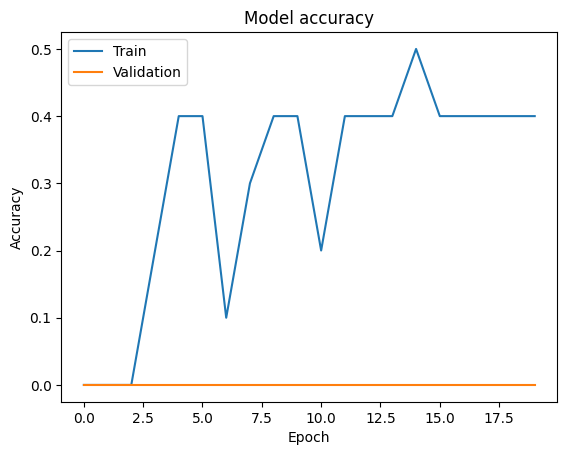

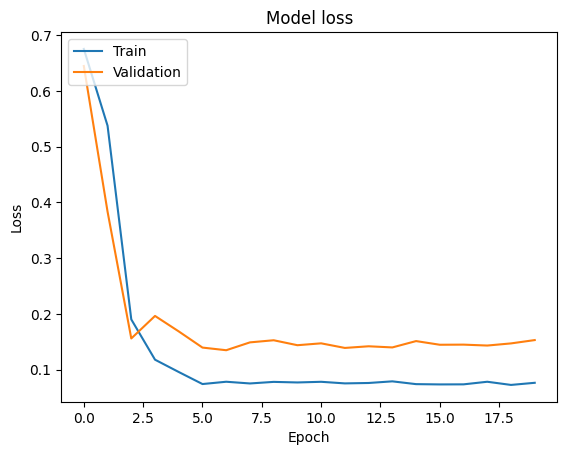

In [57]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


If it does not overfit try to fix data prep and model architecture so it does

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [68]:
import numpy as np

detokenizer = map_int_to_char(characters)

def make_prediction(seed_start, model, tokenizer, seq_len=4, max_gen_length=100):
    # Initialize the generated sequence with the seed
    generated_seq = seed_start
    input_seq = seed_start


    # Loop to generate sequence
    for _ in range(max_gen_length - len(seed_start)):
        # Tokenize the input sequence
        tokenized_input = [tokenizer[c] for c in input_seq]

        # Pad or truncate the input sequence as necessary
        if len(tokenized_input) > seq_len:
            tokenized_input = tokenized_input[-seq_len:]

        # Reshape the input sequence for model prediction
        # Shape: (1, sequence length, 1)
        X_pred = np.reshape(tokenized_input, (1, seq_len, 1))

        # Predict next token probabilities
        y_prob = model.predict(X_pred, verbose=0)[0]
        y_prob = y_prob / np.sum(y_prob)

        # Sample a token based on predicted probabilities
        sampled_token = np.random.choice(list(tokenizer.keys()), p=y_prob)
        # Append the sampled token to the generated sequence
        generated_seq += sampled_token
        if sampled_token == '\n':
          break
        # Update the input sequence for the next round
        input_seq = generated_seq[-seq_len:]

    return generated_seq

# Usage example:
seed_start = "CCCO"
generated_molecule = make_prediction(seed_start, model, tokenizer)
print(f"Generated molecule: {generated_molecule}")


Generated molecule: CCCOrc[cccn[[cnCcrcncccccn)ccccnCcN)rccn)cron2crn)ccccrcSn)ScnCcrcnCcrn)crn)rrcnCcrcn)cn)crccoccnCcr


generate a molecule of your overfitted model

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint_path = "/content/drive/MyDrive/mlbio/model_checkpoint.h5"  # Choose your file path and name
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,  # If True, saves only the best model (measured by 'monitor')
                             save_weights_only=False,  # If True, saves only model weights, else saves the entire model
                             save_freq='epoch')


Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)

X_train, X_test = preprocess(X_train), preprocess(X_test)
y_train, y_test = to_categorical(y_train, vocab_size), to_categorical(y_test, vocab_size)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint])

Epoch 1/10
32198/32204 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.5466
Epoch 1: saving model to /content/drive/MyDrive/mlbio/model_checkpoint.h5
32204/32204 [==============================] - 189s 6ms/step - loss: 0.0605 - accuracy: 0.5466 - val_loss: 0.0501 - val_accuracy: 0.6170
Epoch 2/10
32200/32204 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.6132
Epoch 2: saving model to /content/drive/MyDrive/mlbio/model_checkpoint.h5
32204/32204 [==============================] - 185s 6ms/step - loss: 0.0508 - accuracy: 0.6132 - val_loss: 0.0480 - val_accuracy: 0.6283
Epoch 3/10
32202/32204 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.6226
Epoch 3: saving model to /content/drive/MyDrive/mlbio/model_checkpoint.h5
32204/32204 [==============================] - 185s 6ms/step - loss: 0.0493 - accuracy: 0.6226 - val_loss: 0.0472 - val_accuracy: 0.6337
Epoch 4/10
32201/32204 [============================>.] - ETA: 0s -

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

In [77]:
import random
atoms = ['B', 'C', 'H', 'S', 'O', 'I', 'F']
def count_atoms(molecule: str):
    # Count the number of atoms in a SMILES molecule
    # Note: This is a simplified example and might not cover all SMILES syntax.
    return len([char for char in molecule if char in atoms])

def generate_molecules(model, tokenizer, num_molecules=100, min_atoms=10, max_atoms=50):
    generated_molecules = []
    for _ in tqdm(range(num_molecules)):
        # Start with a random seed (you could also use predefined seeds)
        seed = ""
        for i in range(4):
          seed += (random.choice(atoms))

        generated_molecules.append(make_prediction(seed, model, tokenizer, 4, 50))

    return generated_molecules

# Use the function
num_molecules = 100
generated_molecules = generate_molecules(model, tokenizer, num_molecules=num_molecules)

# Print or analyze the generated molecules
for mol in generated_molecules:
    print(mol)


100%|██████████| 100/100 [03:18<00:00,  1.99s/it]

IFFBrccn)cccNcSrn)crn1cnCcrn)cnNCNnCccnn)rrcn\crcn
CCOIcnCcrocncon)n)NcccnCcn[ncrcnCcnnCrrn)n1cCn)rrO
BOSFn[OcccnCcn)ccccn)ccnCnOcnCcr[n)cncncrNn)ccrncc
HOBOn[ccrrcccs)crrCnCrScn)cccn)CcsccrrCncrScrcrn)r
SHOH)rcncnNrnCcccn)ccnCncrnCcccrnCNcrn)nCr[nCccccr
CFFCnCcrcn)n)crNn)Nccn3crcCcrn

IHHScn)cnCcrcSn

BCIInCn)rCn)cnCcn)ccnCn)rrnlcrn)ccccrn)rrn1n)crnNN
BOIFcrn)corrcnNnNrrconCncn\[rrn)NcNn1rrn

HFBCncccnCNn

IOHBNccnnCrcncccc[nnNrrn1cnCcrcrnCn)cn)crn=)rOcn1c
CIIFcnccccnCcn)n1rNnCcrn)cccnccnCcrsCcornCcSn)ccn3
ICOB[ccnccccrccnCcrcrnCcrnCSn)crnCSrn)cNnCnNccrs)r
FISBrncccrn)c[n1n)cNcccNcnCcnCnCrc[ccnlcrn)ccn)cn)
CBBIrcrn1cnCnoccnCcrn)ccsCcs)ccnCNnrs)rrrcrs)cn[cn
FOIFccn)ccn)cnnCrrnCCccoNnCcrn)NnCcCcrNcrncNn)orn(
FHFOcn1nCcrcnCcrn(ccnCcrnnCccn)ccnCNnCcNccnCcccncc
OFSCccrnCcrnCSrnCcrn)Srrs[crrncn)r[cn)crn)cnCccn)n
ISBH)rnCcrnCn\)rnCSn

HOHOn=)cn)cOns)rcCcrcn)crn4nCrrccccn)crrcoccc[rnCc
SOOInn)rnCcrs)cccnCOrnCn

ICSOnCcNn)crcnCcrOrcnOccrcnnCrNnCcrcnnCrrn)Ncrn)cr
OCOH)cn)nCrNn)ccnCcrn)ccnCcrn)r

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

In [73]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 20.7 MB/s eta 0:00:00


In [82]:
from rdkit import Chem
from rdkit.Chem import QED

# Sample list of SMILES strings representing your molecules

# Initialize an empty list to store QED values
qed_values = []

# Loop through each SMILES string, convert to a Mol object, and calculate its QED
for smiles in generated_molecules:
    try:
      mol = Chem.MolFromSmiles(smiles)
    except e:
      continue
    if mol:  # Check if the molecule was successfully parsed
        qed = QED.qed(mol)  # Calculate QED
        qed_values.append(qed)
# qed_values now contains the QED values for all successfully parsed molecules
qed_values

[22:45:39] SMILES Parse Error: extra close parentheses while parsing: IFFBrccn)cccNcSrn)crn1cnCcrn)cnNCNnCccnn)rrcn\crcn
[22:45:39] SMILES Parse Error: Failed parsing SMILES 'IFFBrccn)cccNcSrn)crn1cnCcrn)cnNCNnCccnn)rrcn\crcn' for input: 'IFFBrccn)cccNcSrn)crn1cnCcrn)cnNCNnCccnn)rrcn\crcn'
[22:45:39] SMILES Parse Error: syntax error while parsing: CCOIcnCcrocncon)n)NcccnCcn[ncrcnCcnnCrrn)n1cCn)rrO
[22:45:39] SMILES Parse Error: Failed parsing SMILES 'CCOIcnCcrocncon)n)NcccnCcn[ncrcnCcnnCrrn)n1cCn)rrO' for input: 'CCOIcnCcrocncon)n)NcccnCcn[ncrcnCcnnCrrn)n1cCn)rrO'
[22:45:39] SMILES Parse Error: syntax error while parsing: BOSFn[OcccnCcn)ccccn)ccnCnOcnCcr[n)cncncrNn)ccrncc
[22:45:39] SMILES Parse Error: Failed parsing SMILES 'BOSFn[OcccnCcn)ccccn)ccnCnOcnCcr[n)cncncrNn)ccrncc' for input: 'BOSFn[OcccnCcn)ccccn)ccnCnOcnCcr[n)cncncrNn)ccrncc'
[22:45:39] SMILES Parse Error: syntax error while parsing: HOBOn[ccrrcccs)crrCnCrScn)cccn)CcsccrrCncrScrcrn)r
[22:45:39] SMILES Parse Error: Failed p

[]

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better